#  Importing TMDB API

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
import os, time, json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook


In [3]:
#importing json librarie
with open(r"\Users\camer\.secret\timdb_api.json", "r") as f:
    login = json.load(f)
    
tmdb.API_KEY = login['api-key']

In [4]:
#test search to ensure success
tmdb.Movies(599).info()

{'adult': False,
 'backdrop_path': '/p47ihFj4A7EpBjmPHdTj4ipyq1S.jpg',
 'belongs_to_collection': None,
 'budget': 1752000,
 'genres': [{'id': 18, 'name': 'Drama'}],
 'homepage': '',
 'id': 599,
 'imdb_id': 'tt0043014',
 'original_language': 'en',
 'original_title': 'Sunset Boulevard',
 'overview': 'A hack screenwriter writes a screenplay for a former silent film star who has faded into Hollywood obscurity.',
 'popularity': 14.379,
 'poster_path': '/sC4Dpmn87oz9AuxZ15Lmip0Ftgr.jpg',
 'production_companies': [{'id': 4,
   'logo_path': '/gz66EfNoYPqHTYI4q9UEN4CbHRc.png',
   'name': 'Paramount',
   'origin_country': 'US'}],
 'production_countries': [{'iso_3166_1': 'US',
   'name': 'United States of America'}],
 'release_date': '1950-08-10',
 'revenue': 5000000,
 'runtime': 110,
 'spoken_languages': [{'english_name': 'English',
   'iso_639_1': 'en',
   'name': 'English'}],
 'status': 'Released',
 'tagline': 'A Hollywood Story.',
 'title': 'Sunset Boulevard',
 'video': False,
 'vote_average'

# Creating and Defining Our Two Functions

In [5]:
#define function for movie rating
def get_movie_with_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    info = movie.info()
    releases = movie.releases()
    for c in releases['countries']:
        if c['iso_3166_1']=='US':
            info['certification'] = c['certification']
    return info

In [6]:
#first test of function
test1 = get_movie_with_rating('tt0848228')
test1

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 140.231,
 'poster_path': '/tYqp6vEOo8YlVWrYQvt9nyOhsA2.jpg',
 'production_companies': [{'id': 420,
   'logo_pat

In [7]:
#second test 
test2 = get_movie_with_rating('tt0332280')
test2

{'adult': False,
 'backdrop_path': '/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg',
 'belongs_to_collection': None,
 'budget': 29000000,
 'genres': [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.newline.com/properties/notebookthe.html',
 'id': 11036,
 'imdb_id': 'tt0332280',
 'original_language': 'en',
 'original_title': 'The Notebook',
 'overview': "An epic love story centered around an older man who reads aloud to a woman with Alzheimer's. From a faded notebook, the old man's words bring to life the story about a couple who is separated by World War II, and is then passionately reunited, seven years later, after they have taken different paths.",
 'popularity': 73.096,
 'poster_path': '/rNzQyW4f8B8cQeg7Dgj3n6eT5k9.jpg',
 'production_companies': [{'id': 12,
   'logo_path': '/iaYpEp3LQmb8AfAtmTvpqd4149c.png',
   'name': 'New Line Cinema',
   'origin_country': 'US'},
  {'id': 1565, 'logo_path': None, 'name': 'Avery Pix', 'origin_country': 'US'},
  {'id': 26

In [8]:
#creating path to save data
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_results_movie_00-01.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2011.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'final_tmdb_data_2013.csv.gz',
 'final_tmdb_data_2014.csv.gz',
 'final_tmdb_data_2015.csv.gz',
 'final_tmdb_data_2016.csv.gz',
 'final_tmdb_data_2017.csv.gz',
 'movies.mwb',
 'results_in_progress_movie_year',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2017.json']

In [9]:
#define function to make json files
def write_json(new_data, filename): 
  
    with open(filename,'r+') as file:
       
        file_data = json.load(file)
      
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
             file.seek(0)
       
             json.dump(file_data, file)

In [10]:
#adding info for years 2000 and 2001
basics = pd.read_csv('Data/title_basics.csv.gz')
YEARS_TO_GET = [2000,2001]
errors = []
 

In [ ]:
#start with outer loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)
    if file_exists == False:
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}], f)
    df = basics.loc[basics['startYear']==YEAR].copy()
    movie_ids = df['tconst'].copy()
    previous_df = pd.read_json(JSON_FILE)
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    #inner loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc = f'Movies from {YEAR}',
                                  position = 1,
                                  leave = True):
        try: 
            temp = get_movie_with_rating(movie_id)
            write_json(temp, JSON_FILE)
            time.sleep(0.02)
        except Exception as e:
            errors.append([movie_id, e])
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

print(f'total error {len(errors)}')
    
                                
                                          

# Exploratory Data Analysis

In [11]:
#inspecting first df
df= pd.read_csv('DATA/final_tmdb_data_2000.csv.gz')
df.head()


,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.5,2.0,NaN


In [12]:
#inspecting second df
df2= pd.read_csv('DATA/final_tmdb_data_2001.csv.gz')
df2.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.3,1158.0,PG-13
2,tt0079644,0.0,/79axmuH1UGkB7m72jjB9rPff9om.jpg,NaN,0.0,"[{'id': 10752, 'name': 'War'}]",NaN,285529.0,id,November 1828,...,0.0,140.0,"[{'english_name': 'Indonesian', 'iso_639_1': '...",Released,NaN,November 1828,0.0,0.0,0.0,NaN
3,tt0089067,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,210258.0,es,El día de los albañiles 2,...,0.0,90.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,The laborers are back full of love and laughs.,El día de los albañiles 2,0.0,7.2,71.0,NaN
4,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.0,3.0,NaN


In [13]:
#combining dataframes
final_df = pd.concat((df, df2), ignore_index=True)
display(final_df.head(),final_df.tail())

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.5,2.0,NaN


,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
4449,tt8929248,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 18, '...",NaN,78417.0,ta,அழகான நாட்கள்,...,0.0,150.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Azhagana Naatkal,0.0,0.0,0.0,NaN
4450,tt8942962,0.0,/gTXCI8ixWjRyll0IwYX4Fk8Mcqe.jpg,NaN,0.0,[],NaN,273575.0,ta,Dosth,...,0.0,0.0,[],Released,NaN,Dost,0.0,3.0,1.0,NaN
4451,tt9071078,0.0,NaN,NaN,0.0,"[{'id': 28, 'name': 'Action'}]",http://www.hkcinemagic.com/en/movie.asp?id=6627,201706.0,cn,致命密函,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Chinese Heroes,0.0,3.0,2.0,NaN
4452,tt9099724,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,616033.0,ja,Rokushukan Private Moment,...,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rokushukan Private Moment,0.0,0.0,0.0,NaN
4453,tt9798698,0.0,NaN,NaN,0.0,[],NaN,580269.0,en,Gay holocaust,...,0.0,0.0,[],Released,NaN,Gay holocaust,0.0,0.0,0.0,NaN


In [14]:
#inspecting new datafram
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                4454 non-null   object 
 1   adult                  4452 non-null   float64
 2   backdrop_path          1950 non-null   object 
 3   belongs_to_collection  248 non-null    object 
 4   budget                 4452 non-null   float64
 5   genres                 4452 non-null   object 
 6   homepage               299 non-null    object 
 7   id                     4452 non-null   float64
 8   original_language      4452 non-null   object 
 9   original_title         4452 non-null   object 
 10  overview               4099 non-null   object 
 11  popularity             4452 non-null   float64
 12  poster_path            3782 non-null   object 
 13  production_companies   4452 non-null   object 
 14  production_countries   4452 non-null   object 
 15  rele

In [15]:
#saving copy of new df
final_df.to_csv('Data/final_results_movie_00-01.csv.gz', compression='gzip',index=False)

In [16]:
#only including movies with financial info more than 0
final_df = final_df.loc[final_df['budget']>0]
final_df = final_df.loc[final_df['revenue']>0] 
final_df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
5,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.filmymen.us/2022/11/in-mood-for-lo...,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.104,2034.0,PG
14,tt0120467,0.0,/knok3mNReKqPTplnnqz7E4dd7mD.jpg,NaN,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,...,14904.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone loves a clown... some more than others.,Vulgar,0.0,5.400,42.0,R
17,tt0120630,0.0,/t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.filmymen.us/2022/11/chicken-run-mo...,7443.0,en,Chicken Run,...,224834564.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,This ain't no chick flick. It's poultry in mot...,Chicken Run,0.0,6.733,4181.0,G
20,tt0120753,0.0,/3vUkQpnwbsFEQlMh9EORpvKJfpo.jpg,NaN,8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,318.0,en,The Million Dollar Hotel,...,105983.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone has something to hide.,The Million Dollar Hotel,0.0,5.900,259.0,R
21,tt0120755,0.0,/24DZfupDlhXeTchmcOkoGRhP5Vg.jpg,"{'id': 87359, 'name': 'Mission: Impossible Col...",125000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,955.0,en,Mission: Impossible II,...,546388105.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Expect the impossible again.,Mission: Impossible II,0.0,6.109,5545.0,PG-13


In [17]:
#inspecting new data
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 5 to 4402
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                373 non-null    object 
 1   adult                  373 non-null    float64
 2   backdrop_path          355 non-null    object 
 3   belongs_to_collection  85 non-null     object 
 4   budget                 373 non-null    float64
 5   genres                 373 non-null    object 
 6   homepage               118 non-null    object 
 7   id                     373 non-null    float64
 8   original_language      373 non-null    object 
 9   original_title         373 non-null    object 
 10  overview               372 non-null    object 
 11  popularity             373 non-null    float64
 12  poster_path            372 non-null    object 
 13  production_companies   373 non-null    object 
 14  production_countries   373 non-null    object 
 15  relea

How many movies had at least some valid financial information (values > 0 for budget OR revenue)?

     - Well it seems after filtering all the values of '0' for Revenue and Budget we are left with 390 movies

How many movies are there in each of the certification categories (G/PG/PG-13/R)?

In [18]:
#inspecting value counts for certification
final_df['certification'].value_counts()

R        144
PG-13    117
PG        29
G         13
NR         6
Name: certification, dtype: int64

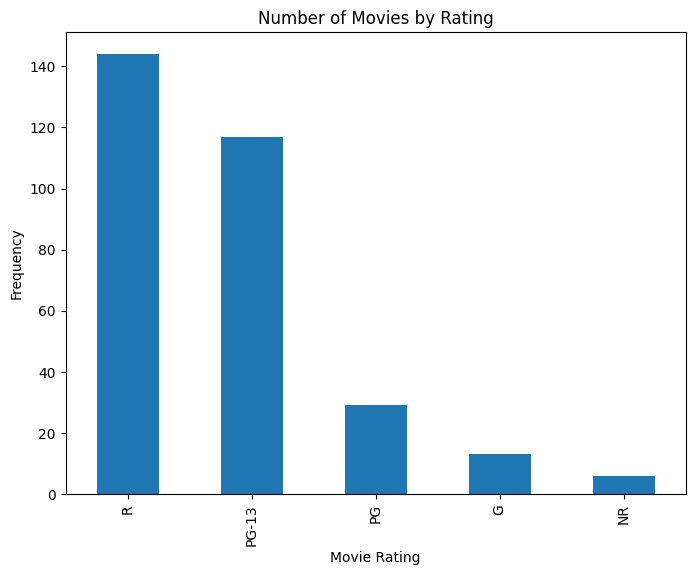

In [19]:
#creating bar graph to display count of each certification
#inspire from https://stackoverflow.com/questions/48939795/how-to-plot-a-count-bar-chart-with-a-pandas-df-grouping-by-one-categorical-colu
ax = final_df['certification'].value_counts().plot(kind='bar',
                                    figsize=(8,6),
                                    title="Number of Movies by Rating")
ax.set_xlabel("Movie Rating")
ax.set_ylabel("Frequency")
plt.show()

As seen above, most movies seems to be R and PG-13 while PG G and 'Not Rated' Movies are in the minority

What is the average revenue per certification category?

In [20]:
#creating variable using groupby
certrev = final_df.groupby('certification')['revenue'].mean()
certrev

certification
G        1.332169e+08
NR       2.382332e+07
PG       1.346138e+08
PG-13    1.110740e+08
R        5.230737e+07
Name: revenue, dtype: float64

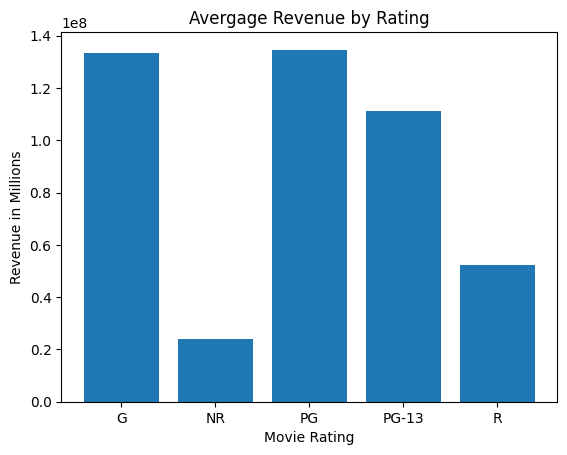

In [21]:
#creating graph for said variable
plt.bar(certrev.index, certrev.values)
plt.title('Avergage Revenue by Rating')
plt.xlabel('Movie Rating')
plt.ylabel('Revenue in Millions')
plt.show()

While they make more R and PG-13 movies, G and PG make the most money possibly due to the higher audience pool

What is the average budget per certification category?

In [22]:
#creating variable using groupby
certbudg = final_df.groupby('certification')['budget'].mean()
certbudg

certification
G        4.400000e+07
NR       1.478333e+07
PG       5.374138e+07
PG-13    4.680682e+07
R        2.695496e+07
Name: budget, dtype: float64

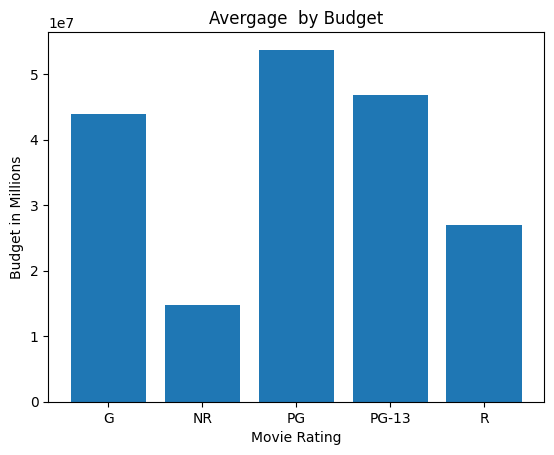

In [23]:
#creatinf final graph
plt.bar(certbudg.index, certbudg.values)
plt.title('Avergage  by Budget')
plt.xlabel('Movie Rating')
plt.ylabel('Budget in Millions')
plt.show()

It seems the movie rating that gets made the least, has the most budget. But, more money goes to PG-13 Movies than G.